## Basic introduction to multivariate mixed functional data, distance measures and outlier detection. We could even add a plot funciton. And scaling and centering.

- construir una situación en la que nos interese estudiar los **outliers**

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skfda import datasets
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot
from skfda.representation.grid import FDataGrid
from skfda.representation import FData

import pandas as pd

import skfda

from skfda.misc.kernels import uniform
from skfda.preprocessing.smoothing import KernelSmoother, BasisSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch

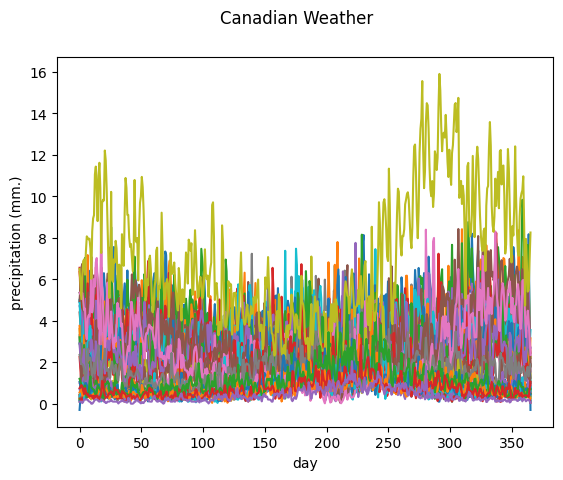

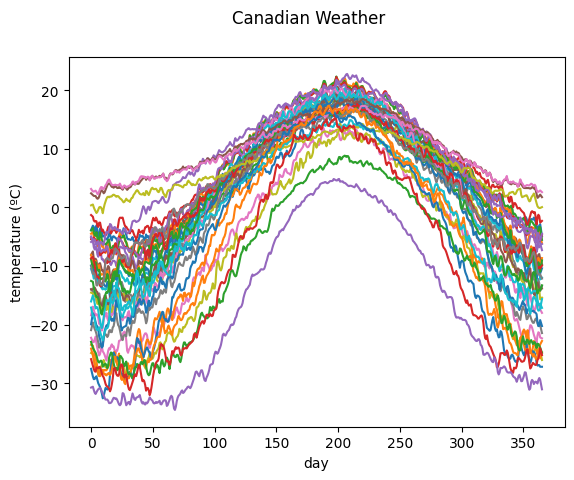

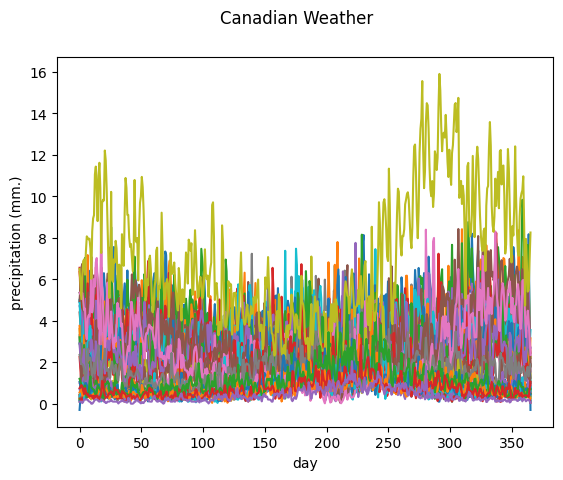

In [2]:
X, y = datasets.fetch_weather(return_X_y=True, as_frame=True)
fd = X.iloc[:, 0].values
fd_temperatures = fd.coordinates[0]
fd_precipitations = fd.coordinates[1]
fd_temperatures.plot()
fd_precipitations.plot()

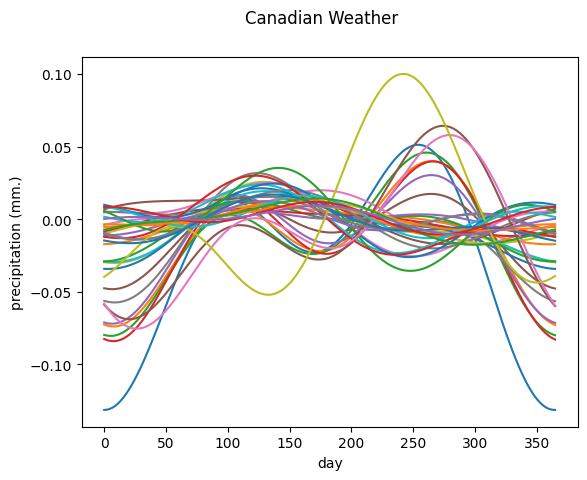

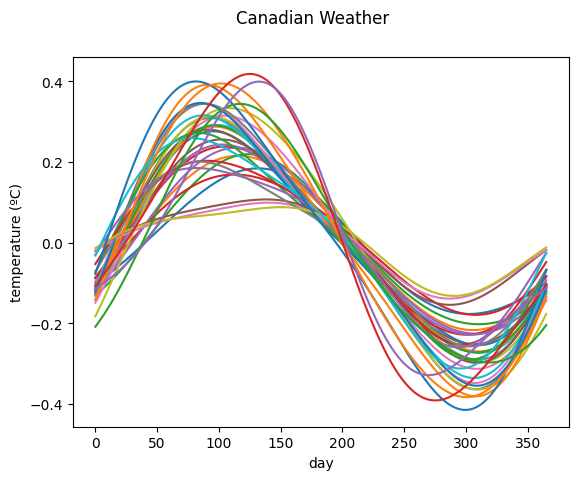

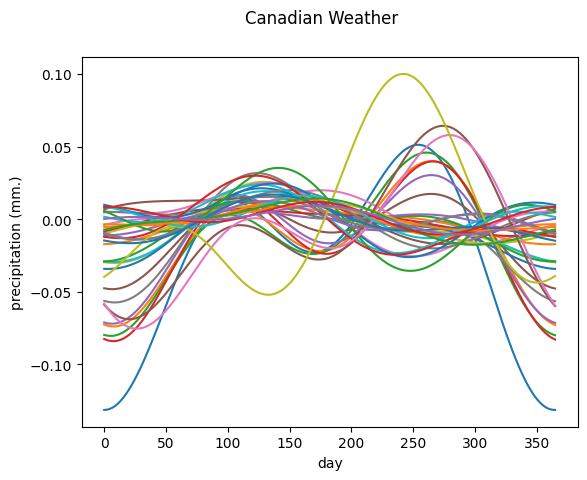

In [3]:
fd_D_temperatures = fd_temperatures.derivative(order=1)
fd_D_precipitations = fd_precipitations.derivative(order=1)

range_temperatures = fd_temperatures.grid_points[0][0], fd_temperatures.grid_points[0][-1]
range_precipitations = fd_precipitations.grid_points[0][0], fd_precipitations.grid_points[0][-1]

basis_temperatures = skfda.representation.basis.FourierBasis(range_temperatures, n_basis=5)
basis_precipitations = skfda.representation.basis.FourierBasis(range_precipitations, n_basis=5)

smoother_temperatures = BasisSmoother(basis=basis_temperatures)
smoother_precipitations = BasisSmoother(basis=basis_precipitations)


fd_D_temperatures_smooth = smoother_temperatures.fit_transform(fd_D_temperatures)
fd_D_precipitations_smooth = smoother_precipitations.fit_transform(fd_D_precipitations)

fd_D_temperatures_smooth.plot()
fd_D_precipitations_smooth.plot()


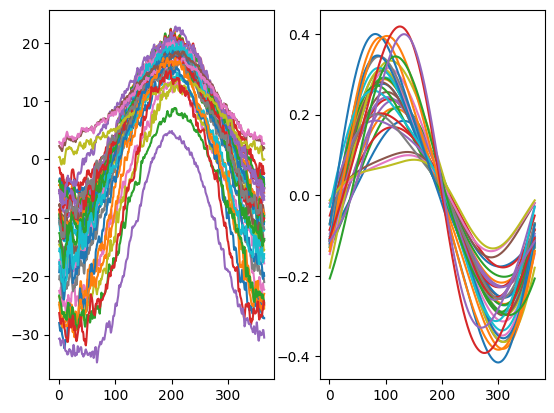

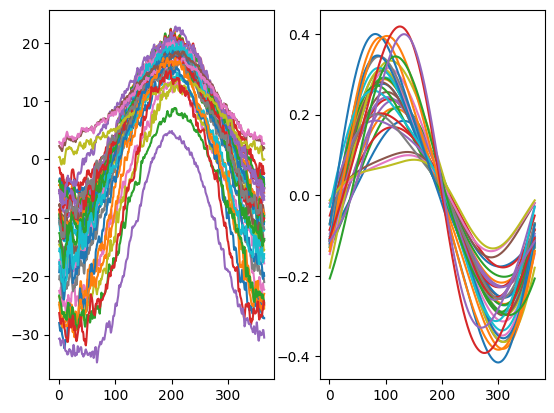

In [4]:
# Create a FDataGrid vector valued with a function and a derivative

data_matrix = np.concatenate([
    fd_temperatures.data_matrix, 
    fd_D_temperatures_smooth.data_matrix
], axis=2) 

fd_vector = FDataGrid(
    data_matrix=data_matrix, 
    grid_points=fd_temperatures.grid_points,
)

# Plot the vector-valued function
fd_vector.plot()

In [ ]:
mixed_df = pd.DataFrame(
    {
        "category": y,
        "temperatures": fd_temperatures,
        "temperature_derivatives": fd_D_temperatures_smooth,
        "precipitations_vector": fd_vector,
    }
)

In [ ]:
from skfda.misc.metrics import PProductMetric

metric = PProductMetric(
    metric=(uniform(), uniform()),
    weights=(1, 1),
)

mean = [collumn.mean() for collumn in mixed_df.collumns]
meand_df = pd.DataFrame(mean, columns= mixed_df.columns)

# Compute distance of each observation to the mean
distances = []
for i in range(len(mixed_df)):
    distances.append(metric(mixed_df.iloc[i], mean))
distances = np.array(distances)
# Find the outliers
outliers = np.where(distances > 2 * np.std(distances))[0]
# Plot the outliers